/var/folders/l8/6mt_wkps2g17l8s9vqw7_k9m0000gp/T/ipykernel_21516/1867745498.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_values['target_month'] = monthly_values['year_month'].shift(-1)


Epoch 1: Loss = 0.0209
Epoch 2: Loss = 0.0172
Epoch 3: Loss = 0.0183
Epoch 4: Loss = 0.0168
Epoch 5: Loss = 0.0172
Epoch 6: Loss = 0.0151
Epoch 7: Loss = 0.0134
Epoch 8: Loss = 0.0119
Epoch 9: Loss = 0.0118
Epoch 10: Loss = 0.0112
Epoch 11: Loss = 0.0124
Epoch 12: Loss = 0.0102
Epoch 13: Loss = 0.0101
Epoch 14: Loss = 0.0107
Epoch 15: Loss = 0.0100
Epoch 16: Loss = 0.0097
Epoch 17: Loss = 0.0097
Epoch 18: Loss = 0.0097
Epoch 19: Loss = 0.0089
Epoch 20: Loss = 0.0096
Epoch 21: Loss = 0.0094
Epoch 22: Loss = 0.0090
Epoch 23: Loss = 0.0087
Epoch 24: Loss = 0.0086
Epoch 25: Loss = 0.0087
Epoch 26: Loss = 0.0088
Epoch 27: Loss = 0.0089
Epoch 28: Loss = 0.0087
Epoch 29: Loss = 0.0084
Epoch 30: Loss = 0.0085
Epoch 31: Loss = 0.0083
Epoch 32: Loss = 0.0091
Epoch 33: Loss = 0.0088
Epoch 34: Loss = 0.0091
Epoch 35: Loss = 0.0085
Epoch 36: Loss = 0.0080
Epoch 37: Loss = 0.0081
Epoch 38: Loss = 0.0088
Epoch 39: Loss = 0.0090
Epoch 40: Loss = 0.0085
Epoch 41: Loss = 0.0080
Epoch 42: Loss = 0.0084
E

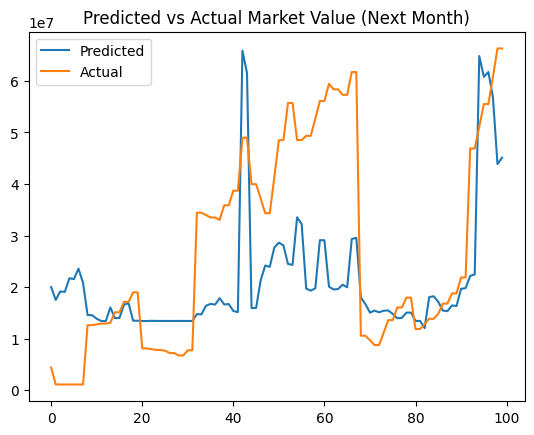

In [9]:
# NOT USED IN FINAL THESIS

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../dataframes/final_versions/daily_encoded.csv", sep="\t", parse_dates=["date"])
monthly = pd.read_csv("../dataframes/final_versions/monthly_encoded.csv", sep="\t", parse_dates=["month"])

# Add monthly marker
df['year_month'] = df['date'].dt.to_period('M')
monthly['year_month'] = monthly['month'].dt.to_period('M')

# Feature engineering
df['neg_news_ratio'] = df['neg_news'] / (df['total_news'] + 1e-5)
df['news_volatility_7d'] = df.groupby('player_id')['total_news'].transform(lambda x: x.rolling(7, min_periods=1).std())
df['reddit_trend'] = df.groupby('player_id')['total_reddit'].transform(lambda x: x.rolling(7, min_periods=1).mean() - x.rolling(30, min_periods=1).mean())
df['neg_news_lag3'] = df.groupby('player_id')['neg_news'].shift(3)
df['total_news_lag3'] = df.groupby('player_id')['total_news'].shift(3)

# Drop weak or noisy features
drop_features = ['sentiment', 'pos_news', 'neg_X', 'neg_mentions']
df = df.drop(columns=[f for f in drop_features if f in df.columns])

# Fill missing data from rolling and shifting
df = df.fillna(0)

# Define selected features
features = [
    'total_mentions', 'pos_mentions',
    'total_X', 'pos_X',
    'total_news', 'neg_news',
    'total_reddit', 'pos_reddit', 'neg_reddit',
    'neg_news_ratio', 'news_volatility_7d', 'reddit_trend',
    'neg_news_lag3', 'total_news_lag3'
]

# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Normalize target market values
value_scaler = MinMaxScaler()
monthly['market_value'] = value_scaler.fit_transform(monthly[['market_value']])

# Prepare target month info
monthly_values = monthly[['player_id', 'year_month', 'market_value']]
monthly_values['target_month'] = monthly_values['year_month'].shift(-1)
monthly_targets = monthly_values[['player_id', 'year_month', 'target_month']]

# Merge to daily
df = pd.merge(df, monthly_targets, on=['player_id', 'year_month'], how='inner')
df = pd.merge(df, monthly[['player_id', 'year_month', 'market_value']],
              left_on=['player_id', 'target_month'],
              right_on=['player_id', 'year_month'],
              suffixes=('', '_target'))

# Sequence setup
sequence_length = 30
X, y = [], []

for player_id, group in df.groupby('player_id'):
    group = group.sort_values('date').reset_index(drop=True)
    for i in range(len(group) - sequence_length):
        window = group.iloc[i:i+sequence_length]
        if window['target_month'].nunique() != 1:
            continue
        target = window['market_value_target'].iloc[-1]
        X.append(window[features].values)
        y.append(target)

X = np.array(X)
y = np.array(y)

# Split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

# Define LSTM model
class MarketValueLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

model = MarketValueLSTM(input_size=X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()

# Train
for epoch in range(50):
    model.train()
    losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}: Loss = {np.mean(losses):.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()
    true_vals = y_test_tensor.squeeze().numpy()

    preds_denorm = value_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
    true_vals_denorm = value_scaler.inverse_transform(true_vals.reshape(-1, 1)).squeeze()

    rmse = np.sqrt(mean_squared_error(true_vals_denorm, preds_denorm))
    r2 = r2_score(true_vals_denorm, preds_denorm)
    print(f"RMSE: {rmse:.2f}, R²: {r2:.4f}")

    plt.plot(preds_denorm[:100], label='Predicted')
    plt.plot(true_vals_denorm[:100], label='Actual')
    plt.legend()
    plt.title('Predicted vs Actual Market Value (Next Month)')
    plt.show()
